### Imports

In [1]:
from main import QuantumIR
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
import numpy as np


IR:

builtin.module {
  "quantum.func"() ({
  ^0(%q0_0 : i1, %q1_0 : i1, %q2_0 : i1, %q3_0 : i1):
    %q4_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q4_1 = "quantum.cnot"(%q0_0, %q4_0) : (i1, i1) -> i1
    %q4_2 = "quantum.cnot"(%q1_0, %q4_1) : (i1, i1) -> i1
    %q5_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q5_1 = "quantum.ccnot"(%q2_0, %q3_0, %q5_0) : (i1, i1, i1) -> i1
    %q5_2 = "quantum.not"(%q5_1) : (i1) -> i1
    %q5_3 = "quantum.cnot"(%q4_2, %q5_2) : (i1, i1) -> i1
    %q5_4 = "quantum.cnot"(%q1_0, %q5_3) : (i1, i1) -> i1
    %q5_5 = "quantum.not"(%q5_4) : (i1) -> i1
    %q6_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q7_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q7_1 = "quantum.cnot"(%q0_0, %q7_0) : (i1, i1) -> i1
    %q7_2 = "quantum.cnot"(%q1_0, %q7_1) : (i1, i1) -> i1
    %q6_1 = "quantum.ccnot"(%q2_0, %q7_2, %q6_0) : (i1, i1, i1) -> i1
    %q5_6 = "quantum.measure"(%q5_5) 

### Generate the IR

In [2]:
# Run
quantum_ir = QuantumIR();
quantum_ir.run_dataclass();
quantum_ir.run_generate_ir();
quantum_ir.run_transformations();


IR:

builtin.module {
  "quantum.func"() ({
  ^0(%q0_0 : i1, %q1_0 : i1, %q2_0 : i1, %q3_0 : i1):
    %q4_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q4_1 = "quantum.cnot"(%q0_0, %q4_0) : (i1, i1) -> i1
    %q4_2 = "quantum.cnot"(%q1_0, %q4_1) : (i1, i1) -> i1
    %q5_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q5_1 = "quantum.ccnot"(%q2_0, %q3_0, %q5_0) : (i1, i1, i1) -> i1
    %q5_2 = "quantum.not"(%q5_1) : (i1) -> i1
    %q5_3 = "quantum.cnot"(%q4_2, %q5_2) : (i1, i1) -> i1
    %q5_4 = "quantum.cnot"(%q1_0, %q5_3) : (i1, i1) -> i1
    %q5_5 = "quantum.not"(%q5_4) : (i1) -> i1
    %q6_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q7_0 = "quantum.init"() {"type" = i1, "value" = false} : () -> i1
    %q7_1 = "quantum.cnot"(%q0_0, %q7_0) : (i1, i1) -> i1
    %q7_2 = "quantum.cnot"(%q1_0, %q7_1) : (i1, i1) -> i1
    %q6_1 = "quantum.ccnot"(%q2_0, %q7_2, %q6_0) : (i1, i1, i1) -> i1
    %q5_6 = "quantum.measure"(%q5_5) 

### Find input and output number

In [3]:
module = quantum_ir.module
funcOp = module.body.block._first_op

# Numbers and type of the input parameters
input_args = funcOp.body.block._args
input_number = input_args.__len__()
input_types = [arg.type for arg in input_args]

# First and last op
first_op = funcOp.body.block._first_op
last_op = funcOp.body.block._last_op
output_number = 0

current = first_op
while(current is not None):
    if current.name == "quantum.init":
        input_number += 1
    if current.name == "quantum.measure":
        output_number += 1
    current = current.next_op

print("Number of inputs: ", input_number, "Number of outputs: ",output_number)

Number of inputs:  6 Number of outputs:  2


### Initialize circuit

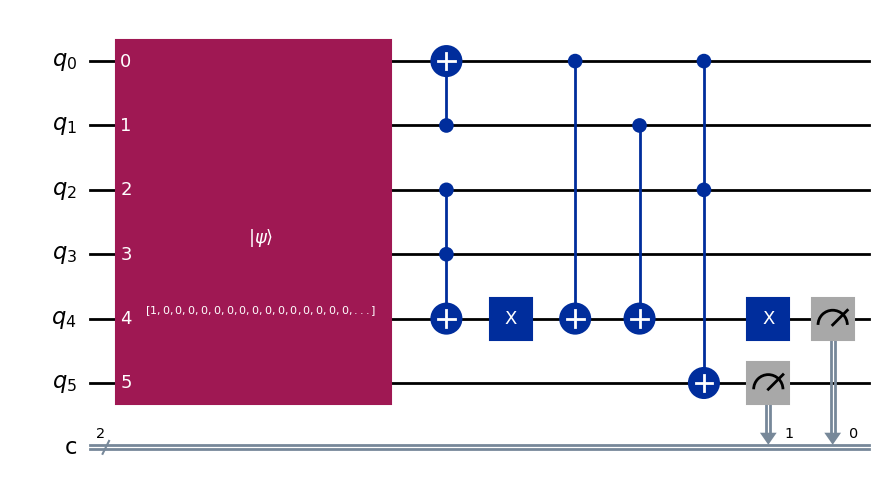

In [4]:

def create_circuit(first_op, input_number, output_number,state):

    circuit = QuantumCircuit(input_number,output_number)
    current = first_op
    cbit_index = 0

    qubit_list = [i for i in range(input_number)]

    circuit.initialize(state,qubit_list)

    while(current is not None):
        # find the indexes of the qubit
        operands_names = [op._name for op in current.operands]
        indexes = [int(name.split("_")[0][1]) for name in operands_names]
        if current.name  == "quantum.cnot":
            circuit.cx(indexes[0],indexes[1])
        if current.name == "quantum.ccnot":
            circuit.ccx(indexes[0],indexes[1],indexes[2])
        if current.name == "quantum.not":
            circuit.x(indexes[0])
        if current.name == "quantum.measure":
            circuit.measure(indexes[0],cbit_index)
            cbit_index+=1
        
        current = current.next_op
    
    return circuit

# initializing it to an example state (e.g. all qubit at 0)
example_state = np.array([1] + [0] * (2**input_number - 1))
create_circuit(first_op, input_number, output_number,example_state).draw(output='mpl')



### Input initilization

In [5]:
from numpy import eye

istates = eye(2**input_number);

def bit_strings_iterative(N):
    bit_list = ['']
    for _ in range(N):
        bit_list = ['0' + bit_string for bit_string in bit_list] + \
                   ['1' + bit_string for bit_string in bit_list]
    return bit_list

# tutte le stringhe di bit di input_number bit
istr = bit_strings_iterative(input_number)

print(istr)
print(istates)

['000000', '000001', '000010', '000011', '000100', '000101', '000110', '000111', '001000', '001001', '001010', '001011', '001100', '001101', '001110', '001111', '010000', '010001', '010010', '010011', '010100', '010101', '010110', '010111', '011000', '011001', '011010', '011011', '011100', '011101', '011110', '011111', '100000', '100001', '100010', '100011', '100100', '100101', '100110', '100111', '101000', '101001', '101010', '101011', '101100', '101101', '101110', '101111', '110000', '110001', '110010', '110011', '110100', '110101', '110110', '110111', '111000', '111001', '111010', '111011', '111100', '111101', '111110', '111111']
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [6]:
from qiskit.providers import JobStatus

counts = {}
backend = AerSimulator()
qubit_list = [i for i in range(input_number)]

for i in range(istates.shape[1]):
    circuit=create_circuit(first_op, input_number, output_number,istates[i])

    job = backend.run(circuit, shots=2000)
    result = job.result()
    
    counts[istr[i]] = result.get_counts()

counts

{'000000': {'00': 2000},
 '000001': {'01': 2000},
 '000010': {'00': 2000},
 '000011': {'01': 2000},
 '000100': {'00': 2000},
 '000101': {'11': 2000},
 '000110': {'10': 2000},
 '000111': {'01': 2000},
 '001000': {'00': 2000},
 '001001': {'01': 2000},
 '001010': {'00': 2000},
 '001011': {'01': 2000},
 '001100': {'01': 2000},
 '001101': {'10': 2000},
 '001110': {'11': 2000},
 '001111': {'00': 2000},
 '010000': {'01': 2000},
 '010001': {'00': 2000},
 '010010': {'01': 2000},
 '010011': {'00': 2000},
 '010100': {'01': 2000},
 '010101': {'10': 2000},
 '010110': {'11': 2000},
 '010111': {'00': 2000},
 '011000': {'01': 2000},
 '011001': {'00': 2000},
 '011010': {'01': 2000},
 '011011': {'00': 2000},
 '011100': {'00': 2000},
 '011101': {'11': 2000},
 '011110': {'10': 2000},
 '011111': {'01': 2000},
 '100000': {'10': 2000},
 '100001': {'11': 2000},
 '100010': {'10': 2000},
 '100011': {'11': 2000},
 '100100': {'10': 2000},
 '100101': {'01': 2000},
 '100110': {'00': 2000},
 '100111': {'11': 2000},


# Metriche
numero di qubit, numero di gate, depth (percorso critico)

In [23]:
print("Number of qubits in the quantum circuit:", circuit.num_qubits)
print("Number of gates in the quantum circuit:", circuit.size())
print("Depth of the quantum circuit:", circuit.depth())
print("Width of the quantum circuit:", circuit.width())

print("Gate counts for the quantum circuit:", circuit.count_ops())

Number of qubits in the quantum circuit: 6
Number of gates in the quantum circuit: 10
Depth of the quantum circuit: 7
Width of the quantum circuit: 8
Gate counts for the quantum circuit: OrderedDict([('cx', 3), ('ccx', 2), ('x', 2), ('measure', 2), ('initialize', 1)])


In [19]:
from qiskit.converters import circuit_to_dag
from qiskit.dagcircuit.dagcircuit import DAGOpNode

# Step 1: Convert to a DAGCircuit
dag = circuit_to_dag(circuit)

# Step 2: Retrieve the critical path
# The critical path is the path corresponding to the depth of the circuit
# Each element in the critical path is a node in the DAG that contributes to this longest path
critical_path = dag.longest_path()
print("Critical Path:")
for node in critical_path:
    if isinstance(node, DAGOpNode):  # Filter to only include operation nodes
        # Extract the qubit indices directly from node.qargs
        qubit_indices = [circuit.qubits.index(q) for q in node.qargs]  # Accessing indices through qubits
        print(f"{node.name} {tuple(qubit_indices)}")

Critical Path:
initialize (0, 1, 2, 3, 4, 5)
ccx (2, 3, 4)
x (4,)
cx (0, 4)
cx (1, 4)
x (4,)
measure (4,)
